In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from matplotlib.ticker import ScalarFormatter

Before presenting our data analysis, we first define some utility functions.

In [2]:
# Computes the FPR for a Bloom filter (assumes that filterSize is expressed in bytes).
def fpr(numElements, filterSize, numHash):
    return np.power(1 - np.exp(-numHash * numElements / (filterSize*8)), numHash)

# Generates a dataframe with statistics on the filters of a BF skip index.
# Each row of the dataframe describes one filter of the index.
# For each filter we report the number of blocks summarized, the estimated number of keys
# in all summarized blocks, the estimated FPR of the filter and its size (in bytes).
def skipProperties(filterSize, numHash, numEntries, avgKeys):
    data = []
    for j in range(0, numEntries):
        numBlocks = 1 << j
        numKeys = avgKeys * numBlocks
        estFpr = fpr(numKeys, filterSize, numHash)
        data.append([numBlocks, numKeys, estFpr, filterSize])
    return pd.DataFrame(data, columns = ['numBlocks', 'estKeys', 'estFpr', 'filterSize'])

# Returns the Hamming weight of an integer.
# Reference: https://en.wikipedia.org/wiki/Hamming_weight
def hamming(n):
    c = 0
    while n:
        c += 1
        n &= n - 1
    return c

# Lower bound for the index-based method.
def minNumVisited(d, numEntries):
    return 1 + np.floor(d / (1 << numEntries)) + hamming(d % (1 << numEntries))

fpRate = np.vectorize(fpr)
linearUpperBound = np.vectorize(lambda d: d+1)
skipLowerBound = np.vectorize(minNumVisited)

# Skip index analysis

For the analysis presented in this notebook, we consuder two different sets of Ethereum blocks.

1. $\mathit{D1}$: the set of the first 15000000 blocks (from height 0 to 14999999).
2. $\mathit{D2}$: the set of blocks between height 14000000 and 14999999 (both included).

We first import data about filters and receipts for all blocks in $\mathit{D1}$.

In [3]:
filters = pd.read_csv('data/filters_ones_0-14999999.csv.xz', compression='xz', header=None, names=['blockId','timestamp','numOnes'])
receipts = pd.read_csv('data/receipt_stats_0-14999999.csv.xz', compression='xz', header=None, names=['blockId', 'txCount', 'numLogs', 'numKeys', 'numUniqueKeys'])

Then we consider data set $\mathit{D1}_{nz}$, namely $\mathit{D1}$ without all blocks having `numUniqueKeys = 0` (i.e., we remove all blocks without any event).

Then we compute three different values corresponding to different levels of saturation of `logsBloom` filters.

In this regard, we consider the distribution of numUniqueKeys in $\mathit{D1}_{nz}$.

- Sparse case: we take the 2nd percentile of the distribution.
- Regular case: we take the median of the distribution.
- Saturated case: we take the 98th percentile of the distribution.

In [26]:
d1nz = receipts[receipts.numUniqueKeys > 0]
p = np.percentile(d1nz.numUniqueKeys, [2, 98])
sparse = p[0]
regular = d1nz.numUniqueKeys.median()
saturated = p[1]
print(f'Sparse:\t\t{sparse}\nRegular:\t{regular}\nSaturated:\t{saturated}')

Sparse:		3.0
Regular:	194.0
Saturated:	692.0


For each of the previous scenarios, we generate a plot describing the estimated false positive probability of the filters of the BF skip index.

The generated plots are as follows:

- On the x-axis we have maximum number of filters $e$ in a single index, with $e \geq 1$.
- On the y-axis we have the estimated false positive rate $f$ for the last filter of a BF skip index with $e$ filters of $m$ bits each, $k$ hash functions and each block includes approximately $n$ distinct keys. The resulting formula to estimate the FPR is 

$$f(n,m,k,e)=\Bigg(1-\exp\Bigg(\frac{-k \cdot n \cdot 2^{e-1}}{m}\Bigg)\Bigg)^k$$

We recall that the last filter of an index is the one that summarizes the longest sequence of predecessor blocks. That is, if the index contains $e$ filters, the last filter summarizes $2^{e-1}$ predecessors.

We test different values for the size $m$ (in bytes), namely $\{256, 512, 1024, 2048, 4096, 8192, 16384\}$, and set $k=3$ as for standard `logsBloom` filters.

To generate such plots, we define the following function.

In [27]:
def skipFigure(numKeys, numHash, maxEntries, title, output_path, legend, y_label):
    sizes = [256, 512, 1024, 2048, 4096, 8192, 16384]
    colors = ['red','orange','yellow','green','blue','purple','gray']
    markers = ['o','v','^','x','X','s','d']
    data = []
    for s in sizes:
        data.append(skipProperties(s, numHash, maxEntries, numKeys))
    fig = plt.figure(figsize=(2.5, 4))
    ax = fig.add_subplot()
    ax.set_prop_cycle(color=colors)
    ax.set_title(f'{title}')
    ax.set_xlabel('Number of filters')
    if y_label:
        ax.set_ylabel('Estimated FPR')
    else:
        ax.yaxis.set_ticklabels([])
    for i in range(0, len(sizes)):
        ax.plot(data[i].index+1, data[i].estFpr, label=f'{sizes[i]}', marker=markers[i], markersize=5)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.5)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    #ax.grid(linestyle='--', linewidth=0.5)
    if legend:
        ax.legend()
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    plt.show()

The following code generates the plots and saves them to the <code>pictures</code> folder.

In [28]:
%%capture
skipFigure(sparse, 3, 12, 'Sparse (2nd perc.)', 'pictures/bf-sparse.pdf', True, True)
skipFigure(normal, 3, 12, 'Regular (median)', 'pictures/bf-normal.pdf', False, False)
skipFigure(saturated, 3, 12, 'Saturated (98th perc.)', 'pictures/bf-saturated.pdf', False, False)

## Contract analysis

In this section we analyze the events triggered by the <a href="https://etherscan.io/address/0x06012c8cf97bead5deae237070f9587f8e7a266d">CryptoKitties Core</a> smart contract within the blocks of $\mathit{D2}$.

Contract address on Mainnet: `0x06012c8cf97bead5deae237070f9587f8e7a266d`

The contract triggers four different events, whose signatures are listed below.

- `Birth(address owner, uint256 kittyId, uint256 matronId, uint256 sireId, uint256 genes)`
- `Transfer(address indexed from, address indexed to, uint256 indexed tokenId)`
- `Approval(address owner, address approved, uint256 tokenId)`
- `Pregnant(address owner, uint256 matronId, uint256 sireId, uint256 cooldownEndBlock)`

Here are the Keccak-256 hashes of the event signatures (they are used to look for occurrences using Bloom filters).

Birth:`0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5` <br>
Transfer: `0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef` <br>
Approval: `0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925` <br>
Pregnant: `0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80` <br>

We import four files containing general statistics about the four main events of the contract. <br>
For each block, we count how many occurrences of the event are included in that block.

In [4]:
e1 = pd.read_csv('data/Birth.csv', header=None, names=['blockId','numBirth'])
e2 = pd.read_csv('data/Transfer.csv', header=None, names=['blockId','numTransfer'])
e3 = pd.read_csv('data/Approval.csv', header=None, names=['blockId','numApproval'])
e4 = pd.read_csv('data/Pregnant.csv', header=None, names=['blockId','numPregnant'])
events = (e1.merge(e2, on='blockId', how='left')
    .merge(e3, on='blockId', how='left')
    .merge(e4, on='blockId', how='left'))
events.head()

,blockId,numBirth,numTransfer,numApproval,numPregnant
0,14000000,0,0,0,0
1,14000001,0,0,0,0
2,14000002,0,0,0,0
3,14000003,0,0,0,0
4,14000004,0,0,0,0


The table below summarizes the occurrence of the four events in $\mathit{D2}$. For each event, we count the total number of occurrences and the number of distinct blocks with at least one occurrence.

In [5]:
total_birth = np.sum(events.numBirth)
total_transfer = np.sum(events.numTransfer)
total_approval = np.sum(events.numApproval)
total_pregnant = np.sum(events.numPregnant)
blocks_birth = np.count_nonzero(events.numBirth)
blocks_transfer = np.count_nonzero(events.numTransfer)
blocks_approval = np.count_nonzero(events.numApproval)
blocks_pregnant = np.count_nonzero(events.numPregnant)
pd.DataFrame({'Event':['Birth','Transfer','Approval','Pregnant'], 
              'N. of occurrences':[total_birth,total_transfer,total_approval,total_pregnant],
              'N. of blocks':[blocks_birth,blocks_transfer,blocks_approval,blocks_pregnant]})

,Event,N. of occurrences,N. of blocks
0,Birth,2212,2169
1,Transfer,24313,16660
2,Approval,5763,5183
3,Pregnant,2227,2160


We now generate a dataframe with aggregated statistics about event occurrences in $\mathit{D2}$. We split $\mathit{D2}$ in chunks of 2500 contiguous blocks and compute the following statistics for each chunk.

- Number of Birth, Transfer, Approval and Pregnant events in the chunk.
- Total number of event occurrences (i.e., sum of all Birth, Transfer, Approval and Pregnant occurrences).
- Percentage of Birth, Transfer, Approval and Pregnant occurrences over total.
- Timestamp of the lower endpoint (i.e., the lower block height) of the chunk.

In [6]:
heights = events.blockId.values
birth = events.numBirth.values
transfer = events.numTransfer.values
approval = events.numApproval.values
pregnant = events.numPregnant.values
step = 2500
histBins = np.arange(np.min(heights), np.max(heights)+step, step)
s_birth = stats.binned_statistic(heights, birth, statistic='sum', bins=histBins)
s_transfer = stats.binned_statistic(heights, transfer, statistic='sum', bins=histBins)
s_approval = stats.binned_statistic(heights, approval, statistic='sum', bins=histBins)
s_pregnant = stats.binned_statistic(heights, pregnant, statistic='sum', bins=histBins)
x = pd.DataFrame({'blockId':s_birth.bin_edges[:-1],
                  'birth':s_birth.statistic,
                  'transfer':s_transfer.statistic,
                  'approval':s_approval.statistic,
                  'pregnant':s_pregnant.statistic})
x['blockId'] = x.blockId.astype(int)
x['sum'] = x['birth'] + x['transfer'] + x['approval'] + x['pregnant']
x['birthPerc'] = x['birth']/x['sum']
x['transferPerc'] = x['transfer']/x['sum']
x['approvalPerc'] = x['approval']/x['sum']
x['pregnantPerc'] = x['pregnant']/x['sum']
x = x.merge(filters[['blockId','timestamp']], on=['blockId'], how='left')
x = x.fillna(0)
x

,blockId,birth,transfer,approval,pregnant,sum,birthPerc,transferPerc,approvalPerc,pregnantPerc,timestamp
0,14000000,2.0,39.0,14.0,0.0,55.0,0.036364,0.709091,0.254545,0.000000,1642114795
1,14002500,4.0,47.0,5.0,4.0,60.0,0.066667,0.783333,0.083333,0.066667,1642147969
2,14005000,6.0,113.0,71.0,2.0,192.0,0.031250,0.588542,0.369792,0.010417,1642181560
3,14007500,2.0,127.0,52.0,3.0,184.0,0.010870,0.690217,0.282609,0.016304,1642215157
4,14010000,3.0,75.0,9.0,4.0,91.0,0.032967,0.824176,0.098901,0.043956,1642249414
...,...,...,...,...,...,...,...,...,...,...,...
395,14987500,3.0,50.0,0.0,3.0,56.0,0.053571,0.892857,0.000000,0.053571,1655592471
396,14990000,12.0,56.0,1.0,12.0,81.0,0.148148,0.691358,0.012346,0.148148,1655630387
397,14992500,5.0,26.0,0.0,14.0,45.0,0.111111,0.577778,0.000000,0.311111,1655667460
398,14995000,3.0,44.0,0.0,2.0,49.0,0.061224,0.897959,0.000000,0.040816,1655704684


We then use the previous dataframe to generate two plots.

1. The first plot shows the frequency of each event, expressed as a percentage over the total number of occurrences in the chunk. Each vertical bar refers to a chunk of 2500 consecutive blocks and is colored so as to reflect the proportion of event occurrences within that chunk.

2. The second plot illustrates the cumulative frequencies of the Birth, Transfer, Approval and Pregnant events within $\mathcal{D2}$.

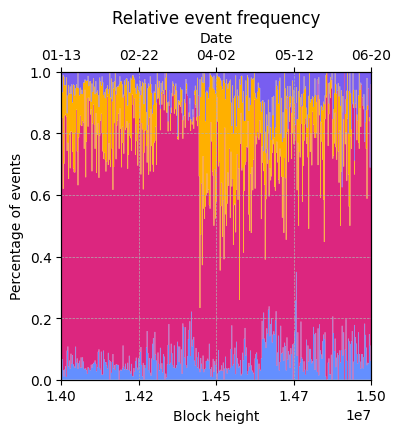

In [7]:
class CustomScalarFormatter(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.2f"

dates = x.timestamp.astype(dtype='datetime64[s]')
n_ticks = 5
x1_min = x['blockId'].min()
x1_max = x['blockId'].max()
x2_min = dates.min()
x2_max = dates.max()

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot()
ax1.set_title('Relative event frequency')
ax1.set_xlabel('Block height')
ax1.set_ylabel('Percentage of events')
ax1.stackplot(x['blockId'], x['birthPerc'], x['transferPerc'], x['approvalPerc'], x['pregnantPerc'],
             colors=['#648fff','#dc267f','#ffb000','#785ef0'], 
             labels=['Birth', 'Transfer', 'Approval', 'Pregnant'], 
             step='post')
ax1.set_xticks(np.linspace(x1_min, x1_max, n_ticks, dtype=int))
ax1.set_xlim(x1_min, x1_max)
ax1.grid(linestyle='--', linewidth=0.5)
ax1.margins(0,0)
ax1.xaxis.set_major_formatter(CustomScalarFormatter())

ax2 = ax1.twiny()
ax2.set_xlabel('Date')
ax2.set_xticks(pd.date_range(start=x2_min, end=x2_max, periods=n_ticks))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.set_xlim(x2_min, x2_max)
ax2.margins(0,0)

plt.savefig("pictures/cryptokitties_frequency_perc.pdf", format='pdf', bbox_inches='tight')
plt.show()

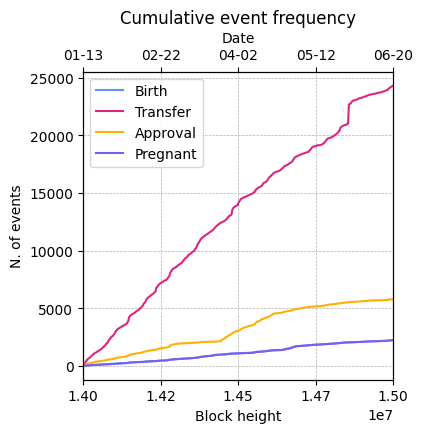

In [172]:
n_ticks = 5

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot()
ax1.set_title('Cumulative event frequency')
ax1.set_xlabel('Block height')
ax1.set_ylabel('N. of events')
ax1.plot(x['blockId'], np.cumsum(x['birth']), color='#648fff', label='Birth')
ax1.plot(x['blockId'], np.cumsum(x['transfer']), color='#dc267f', label='Transfer')
ax1.plot(x['blockId'], np.cumsum(x['approval']), color='#ffb000', label='Approval')
ax1.plot(x['blockId'], np.cumsum(x['pregnant']), color='#785ef0', label='Pregnant')
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_xticks(np.linspace(x1_min, x1_max, n_ticks, dtype=int))
ax1.set_xlim(x1_min, x1_max)
ax1.xaxis.set_major_formatter(CustomScalarFormatter())

ax2 = ax1.twiny()
ax2.set_xlabel('Date')
ax2.set_xticks(pd.date_range(start=x2_min, end=x2_max, periods=n_ticks))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.set_xlim(x2_min, x2_max)

ax1.legend(loc='upper left')
plt.savefig("pictures/cryptokitties_frequency_cumul.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Query generation

Finally, we use the event occurrences of the CryptoKitties Core smart contract to compile a data set of queries.<br>
In particular, we focus on the Birth and Transfer events, which represent, respectively, the least and most frequent events for the contract.<br>
To generate our data set, we proceed as follows.

- Suppose that $l$ and $r$ represent, respectively, the minimum and maximum block height.
- Suppose that the event $X$ has $n$ occurrences, located at blocks $\{{s_1},\dots,{s_n}\}$, with $l \leq s_1 < \dots < s_n \leq u$.
- The first query for $X$ is represented by the range $[s_n, u]$.
- The second query for $X$ is represented by the range $[s_{n-1}, s_{n}-1]$.
- ...
- The $n$-th query for $X$ is represented by the range $[s_1, s_2-1]$.

This process is implemented within the following function, which can be used to generate the query data sets. The generated queries will be used for assessing the effectiveness of our index implementation.

In [173]:
def generateQueries(events, eventName):
    solutions = events[events[f'num{eventName}'] > 0].blockId.values
    upper = events.blockId.max()
    lower = events.blockId.min()
    f = open(f'data/queries_{eventName.lower()}.csv', 'w')
    for i in reversed(range(0, len(solutions))):
        where = solutions[i]
        f.write(f'{upper},{lower},{where}\n')
        upper = where - 1
    f.close()

In [174]:
generateQueries(events, 'Birth')
generateQueries(events, 'Transfer')